In [1]:
import os
import errno
import numpy as np 
import xarray as xr
import deepcell
from deepcell.applications import MultiplexSegmentation

In [29]:
# load data
data_dir = '/data/segmentation/20200227_IF_Testing/melanoma/'
#data_dir = '/data/alex/2020325_test_image/'
data_dir = '/data/segmentation/20200227_IF_Testing/test_data/eliot'
data_dir = '/data/segmentation/20200209_CyCIF/'
data_dir = '/data/segmentation/datasets/20200226_Melanoma/20200627_Melanoma'
#data_dir = '/data/segmentation/datasets/20200114_cHL/20200522_cHL_job/'
#data_dir = '/data/segmentation/datasets/20200116_DCIS/20200618_DCIS'
#data_dir = '/data/segmentation/datasets/20191219_Eliot/20200616_Eliot_Screen2/'
#data_dir = '/data/segmentation/20200616_Model_Assessment'
# data_dir = '/data/selena/20200703_GI_test/'
# data_dir = '/data/segmentation/datasets/20200219_Roshan/20200720_Roshan/'
#data_dir = '/data/segmentation/20200709_CODEX_SM'
data_dir = '/data/segmentation/datasets/20200526_COH_BC/20200730_COH_BC'
data_dir = '/data/segmentation/datasets/20200624_graham_pancreas/'
data_dir = '/data/segmentation/datasets/20200624_CODEX_Panc/20200804_CODEX_Panc'

In [30]:
cohort_xr = xr.open_dataarray(os.path.join(data_dir,'deepcell_input.xr'))
cohort_xr.shape

(144, 512, 512, 2)

In [4]:
vals = np.zeros(list(cohort_xr.shape[:-1]) + [2])
vals[:, :, :, 0] = cohort_xr.values[..., 0]

In [4]:
app = MultiplexSegmentation(use_pretrained_weights=False)

W0804 15:25:19.490404 140634557970240 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
# compartment
weights = "/data/models/20200619_production_updates/20200802_all_data_512x512_compartment_deep_watershed.h5"

In [5]:
# whole-cell
weights = "/data/models/20200619_production_updates/20200720_all_data_512x512_deep_watershed.h5"

In [6]:
app.model.load_weights(weights)

In [54]:
output = app.predict(image=cohort_xr.values, image_mpp=0.75, compartment='whole-cell', 
                     postprocess_kwargs_whole_cell={'maxima_threshold': 0.1, 'maxima_model_smooth': 0,
                                                   'interior_model_smooth': 2, 'interior_threshold': 0.25}, 
                     postprocess_kwargs_nuclear={'interior_threshold': 0.6, 'interior_model_smooth': 0,
                                                'maxima_model_smooth': 0})

In [43]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            if np.sum(input_data[img, :, :, channel] > 0):
                percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                                [0, 95])
                rescaled_intensity = rescale_intensity(input_data[img, :, :, channel].astype('float32'),
                                                           in_range=(percentiles[0], percentiles[1]),
                                                           out_range='float32')
                RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [47]:
RGB_data = make_color_overlay(cohort_xr.values[:20])

In [55]:
predicted_overlay = make_outline_overlay(RGB_data, output[:20, :, :, 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until


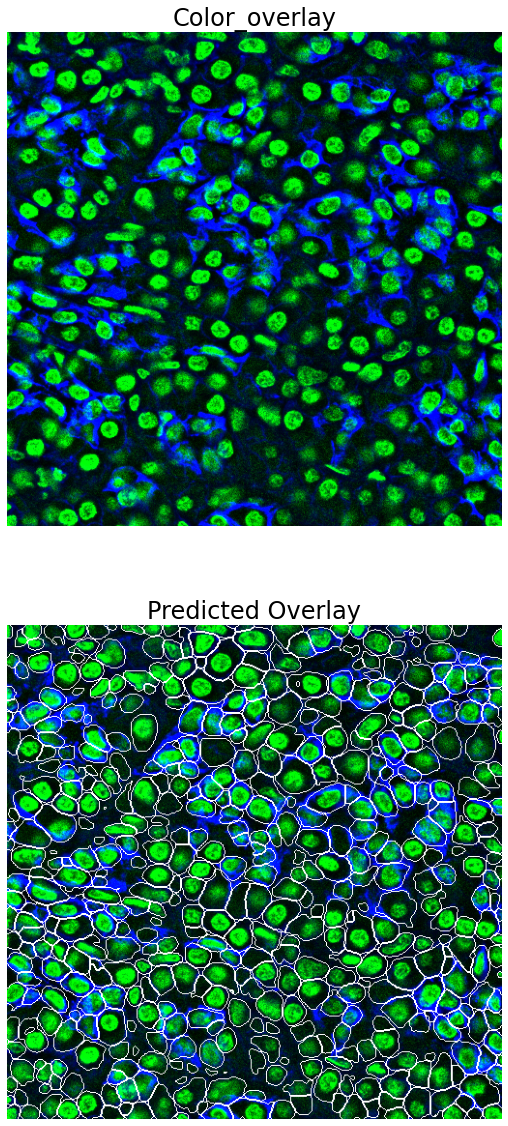

In [57]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = [18]
fig, axes = plt.subplots(2,1,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(RGB_data[index[0],:, :, :])
axes[1].imshow(predicted_overlay[index[0], :, :, :], cmap=cmap)

axes[0].set_title('Color_overlay', fontsize=24)
axes[1].set_title('Predicted Overlay', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until
W0723 16:56:13.384273 140390807365440 image.py:717] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0723 16:56:13.388255 140390807365440 image.py:717] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


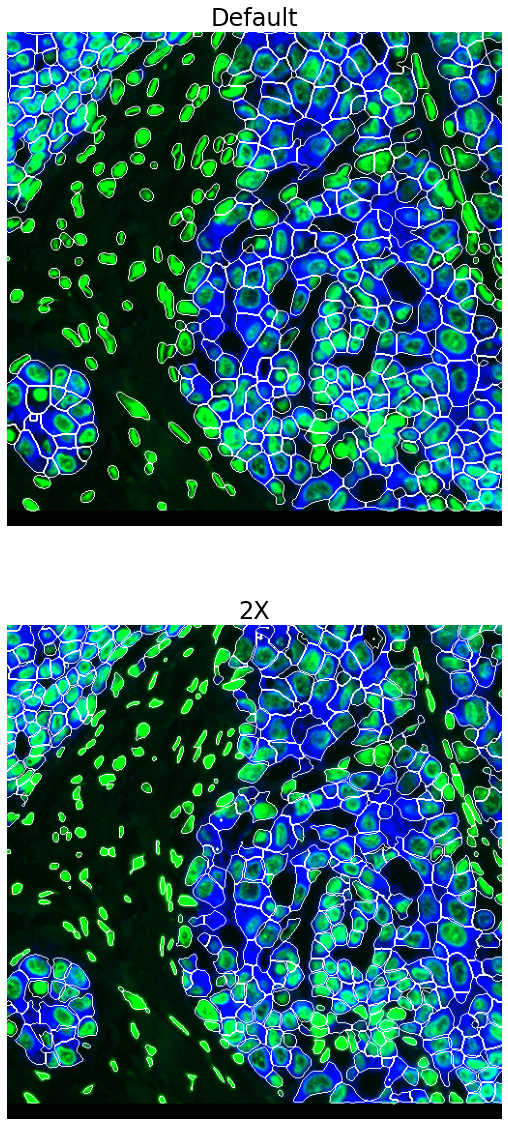

In [39]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = [7]
fig, axes = plt.subplots(2,1,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(predicted_overlay_default[index[0], :, :, :], cmap=cmap)
axes[1].imshow(predicted_overlay[index[0], :, :, :], cmap=cmap)

axes[0].set_title('Default', fontsize=24)
axes[1].set_title('2X', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()

In [58]:
segmentation_labels = xr.DataArray(output,
                         coords=[cohort_xr.coords['fovs'], range(cohort_xr.shape[1]), 
                                 range(cohort_xr.shape[2]), 
                                 ['whole_cell']],
                         dims=['fovs', 'rows', 'cols', 'compartments'])
segmentation_labels.to_netcdf(os.path.join(data_dir, "segmentation_labels.xr"), format="NETCDF3_64BIT")

In [44]:
cohort_xr.fovs[:5]

<xarray.DataArray 'fovs' (fovs: 5)>
array(['P103_T1T3_Point16_crop_0', 'P103_T1T3_Point16_crop_1',
       'P103_T1T3_Point16_crop_2', 'P103_T1T3_Point16_crop_3',
       'P103_T1T3_Point17_crop_0'], dtype=object)
Coordinates:
  * fovs     (fovs) object 'P103_T1T3_Point16_crop_0' ... 'P103_T1T3_Point17_crop_0'

In [9]:
resized_input = app._resize_input(cohort_xr.values, image_mpp=0.5)
resized_input.shape

(100, 512, 512, 2)

In [10]:
inner_distance, outer_distance, fgbg, pixelwise = app._run_model(resized_input)

ValueError: not enough values to unpack (expected 4, got 2)

In [10]:
combined = np.concatenate((pixelwise[:, :, :, 1:2], pixelwise[:, :, :, 0:1], 
                           inner_distance, outer_distance, fgbg[:, :, :, 1:2]), axis=-1)
combined.shape

(100, 512, 512, 5)

In [11]:
from deepcell_toolbox.utils import resize
resized_output = resize(combined, cohort_xr.shape[1:3])
resized_output.shape

(100, 512, 512, 5)

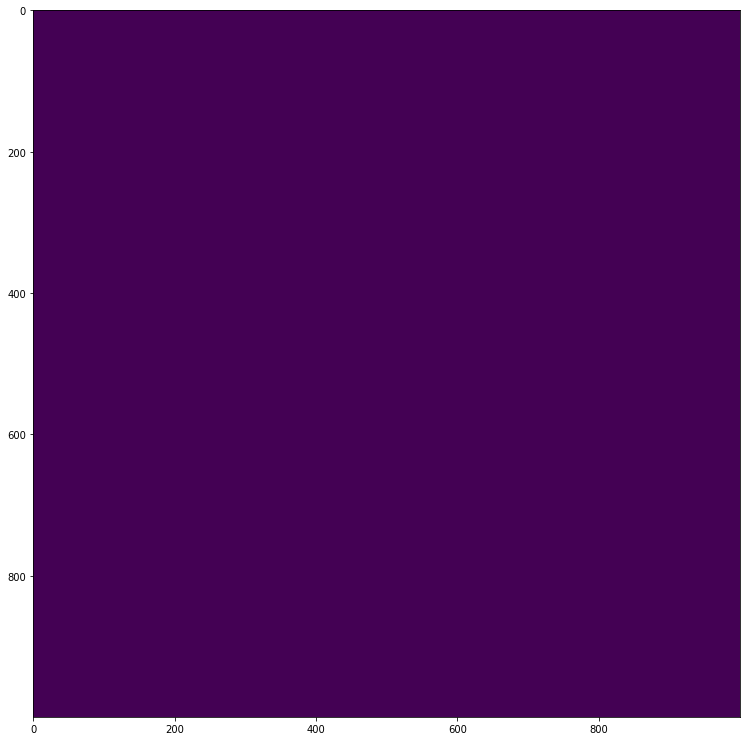

In [17]:
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(vals[0, 1000:2000, 1000:2000, 0])

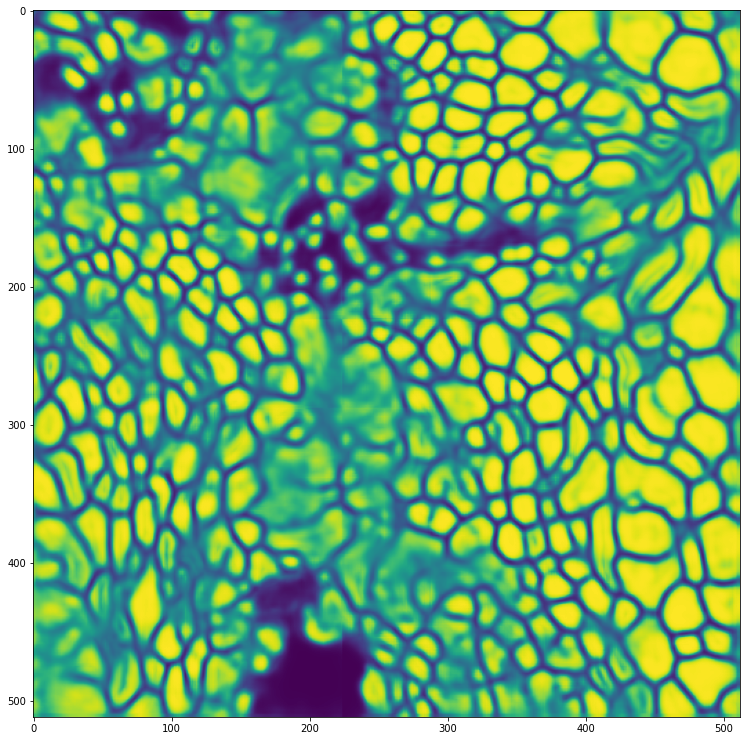

In [17]:
# Original IF_Test_8 model
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(resized_output[30, :, :, 0])

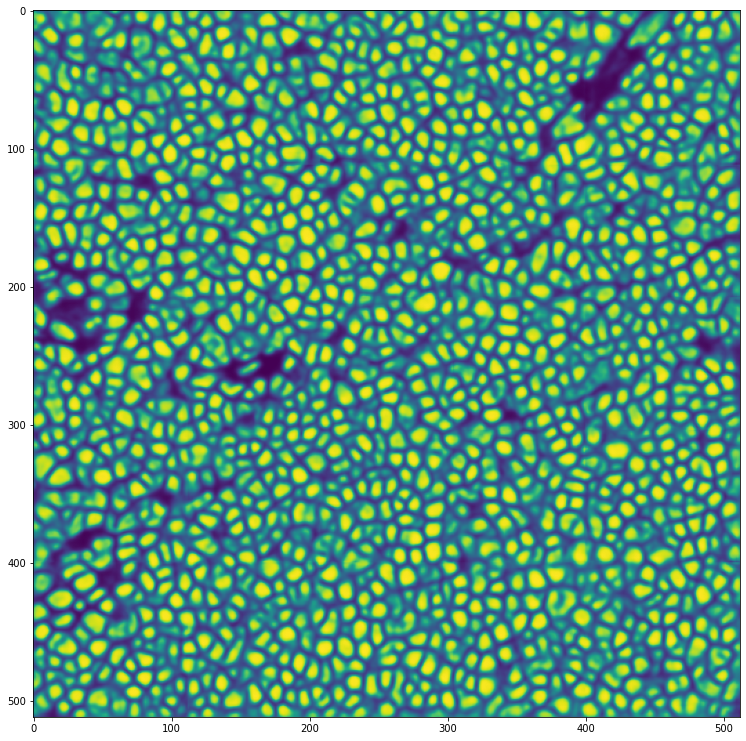

In [16]:
# working version
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(resized_output[18, :, :, 0])

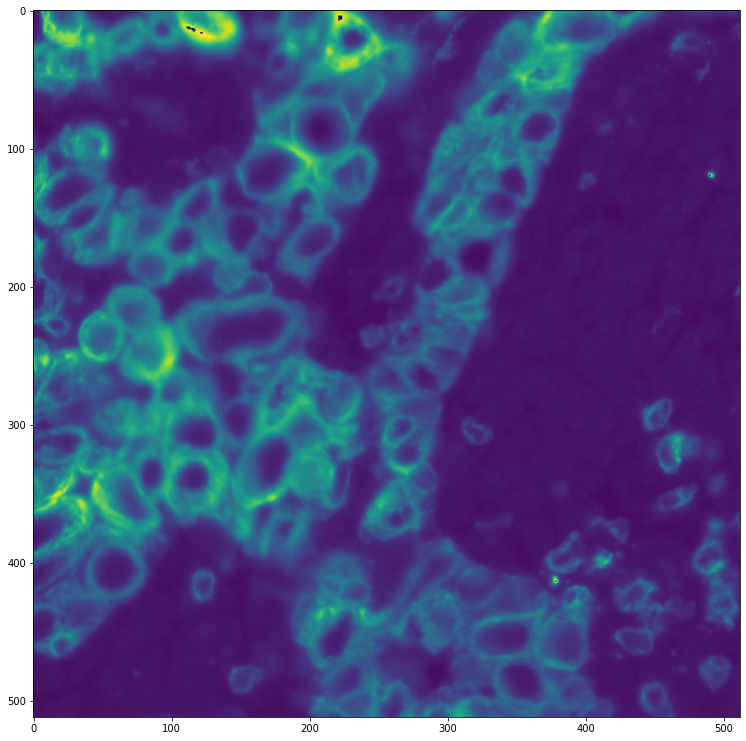

In [12]:
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr[0, :, :, 1])

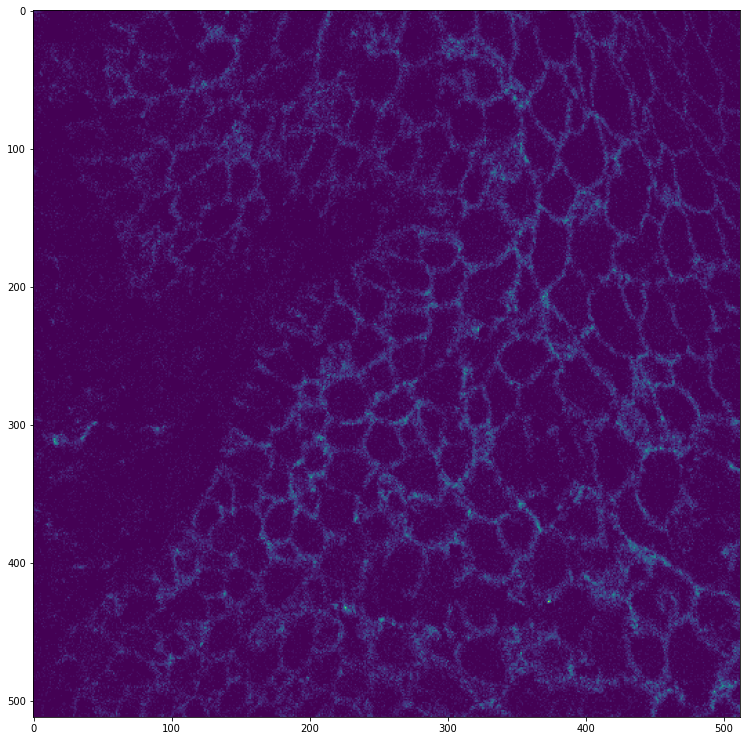

In [14]:
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr[1, :, :, 1])

In [18]:
model_output = xr.DataArray(resized_output,
                         coords=[cohort_xr.coords['fovs'], range(cohort_xr.shape[1]), 
                                 range(cohort_xr.shape[2]), 
                                 ['pixelwise_interior', 'pixelwise_border', 'watershed_inner', 
                                  'watershed_outer', 'fgbg_foreground']],
                         dims=['fovs', 'rows', 'cols', 'models'])
model_output.to_netcdf(os.path.join(data_dir, "deepcell_output.xr"), format="NETCDF3_64BIT")

In [12]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=(256,256, 2),
    norm_method=None,
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

In [13]:
model.load_weights(weights)

In [15]:
from deepcell_toolbox.utils import tile_image, untile_image
from deepcell_toolbox.processing import phase_preprocess
preprocessed = phase_preprocess(cohort_xr.values, 128)

In [22]:
tiled_data, tile_info = tile_image(preprocessed, model_input_shape=(256, 256), stride_ratio=1)
model_output = model.predict(tiled_data)

In [23]:
inner_distance_untile = untile_image(model_output[0], tile_info)
pixelwise_untile = untile_image(model_output[3], tile_info)

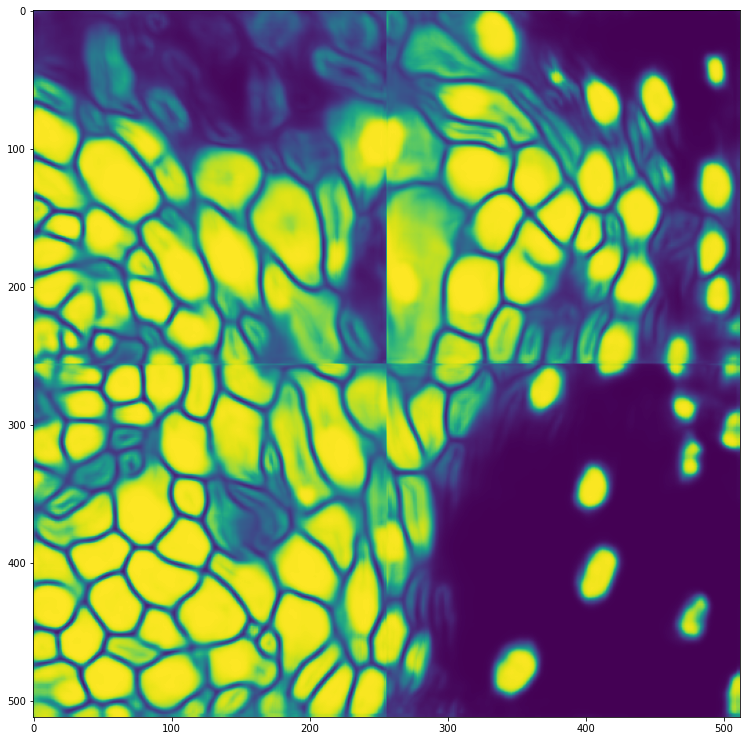

In [27]:
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(pixelwise_untile[40, :, :, 1])

In [28]:
combined = np.concatenate((pixelwise_untile[:, :, :, 1:2],
                           inner_distance_untile), axis=-1)
combined.shape

(224, 512, 512, 2)

In [30]:
deepcell_output = xr.DataArray(combined,
                         coords=[cohort_xr.coords['fovs'], range(cohort_xr.shape[1]), 
                                 range(cohort_xr.shape[2]), 
                                 ['pixelwise_interior', 'watershed_inner']],
                         dims=['fovs', 'rows', 'cols', 'channels'])
deepcell_output.to_netcdf(os.path.join(data_dir, "deepcell_output.xr"), format="NETCDF3_64BIT")